## CT5133 / CT5145 Deep Learning (/Online) 2022-2023

## Ankit Juneja

**Due date**: midnight Sunday 19 March (end Week 10).

**Weighting**: 20% of the module.

In this Project the goal is to take advantage of pre-trained NN models to create an embedding with a dataset of movie posters, and demonstrate how to use that embedding.

The dataset is provided, along with some skeleton code for loading it.

The individual steps to be carried out are specified below, with `### YOUR CODE HERE` markers, together with the number of marks available for each part.

* **Topics**: in Part 5 below, students are asked to add some improvement to their models. In general, these improvements will differ between students (or student groups). **The proposed improvement must be notified to the lecturer at least 1 week before submission, and approved by the lecturer**. If working in a group, the two members of the group should not work on different topics in Part 5: they must work on the same topic and submit identical submissions.

* Students are not required to work incrementally on the parts. It is ok to do all the work in one day, so long as you abide by the rules on notifying groups and notifying topics.

* **Groups**: students may work solo or in a group of two. A student may not work together in a group with any student they have previously worked on a group project with, in this module or any other in the MSc programme. **Groups must be notified to the lecturer in writing before beginning work and at least 1 week before submission.** If working in a group, both students must submit and both submissions must be identical. If working in a group, both students may be asked to explain any aspect of the code in interview (see below), therefore working independently on separate components is not recommended. Any emails concerning the project should be cc-ed to the other group member.

* **Libraries**: code can be written in Keras/Tensorflow, or in PyTorch. 

* **Plagiarism**: students may discuss the assignment together, but you may not look at another student or group's work or allow other students to view yours (other than within a group). You may use snippets of code (eg 1-2 lines) from the internet, **if you provide a citation with URL**. You may also use a longer snippet of code if it is a utility function, again only with citation. You may not use code from the internet to carry out the core of the assignment. You may not use a large language model to generate code.

* **Submission**: after completing your work in this Jupyter notebook, submit the notebook both in `.ipynb` and `.pdf` formats. The content should be identical.

* **Interviews**: a number of students may be selected for interview, post-submission. The selection will depend on submissions, and random chance may be used also. Interviews will be held in-person (CT5133) or online (CT5145). Interviews will last approximately 10 minutes. The purpose of interviews will be to assess students' understanding of their own submission.


### Dataset Credits

The original csv file is from: 

https://www.kaggle.com/datasets/neha1703/movie-genre-from-its-poster

I have added the *year* column for convenience.

I believe most of the information is originally from the famous MovieLens dataset:

* https://grouplens.org/datasets/movielens/
* https://movielens.org/

However, I'm not clear whether the poster download URLs (Amazon AWS URLs) which are in the csv obtained from the Kaggle URL above are from a MovieLens source, or elsewhere.

To create the dataset we are using, I have randomly sampled a small proportion of the URLs in the csv, and downloaded the images. I have removed those which fail to download. Code below also filters out those which are in black and white, ie 1 channel only.

### Imports

You can add more imports if needed.

In [1]:
import numpy as np
import pandas as pd
import os
from PIL import Image
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist, pdist, squareform # useful for distances in the embedding

In [2]:
import tensorflow as tf
from tensorflow import keras
from keras import layers, models

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense,Dropout
from keras.optimizers import Adam
from tensorflow.keras.layers import Reshape
from tensorflow.keras.losses import Huber

### Utility functions

These functions are provided to save you time. You might not need to understand any of the details here.

In [4]:
# walk the directory containing posters and read them in. all are the same shape: (268, 182).
# all have 3 channels, with a few exceptions (see below).
# each is named <imdbId>.jpg, which will later allow us to get the metadata from the csv.
IDs = []
images = []
for dirname, _, filenames in os.walk('DL_Sample'):
    for filename in filenames:
        if filename.endswith(".jpg"):
            ID = int(filename[:-4])
            pathname = os.path.join(dirname, filename)
            im = Image.open(pathname)
            imnp = np.array(im, dtype=float)
            if len(imnp.shape) != 3: # we'll ignore a few black-and-white (1 channel) images
                print("This is 1 channel, so we omit it", imnp.shape, filename)
                continue # do not add to our list
            IDs.append(ID)
            images.append(imnp)

In [5]:
img_array = np.array(images)

In [6]:
img_array.shape[1:]

(268, 182, 3)

In [7]:
# read the csv
df = pd.read_csv("Movie_Genre_Year_Poster.csv", encoding="ISO-8859-1", index_col="Unnamed: 0")
df.head()

,imdbId,Imdb Link,Title,IMDB Score,Genre,Poster,Year
0,114709,http://www.imdb.com/title/tt114709,Toy Story (1995),8.3,Animation|Adventure|Comedy,https://images-na.ssl-images-amazon.com/images...,1995.0
1,113497,http://www.imdb.com/title/tt113497,Jumanji (1995),6.9,Action|Adventure|Family,https://images-na.ssl-images-amazon.com/images...,1995.0
2,113228,http://www.imdb.com/title/tt113228,Grumpier Old Men (1995),6.6,Comedy|Romance,https://images-na.ssl-images-amazon.com/images...,1995.0
3,114885,http://www.imdb.com/title/tt114885,Waiting to Exhale (1995),5.7,Comedy|Drama|Romance,https://images-na.ssl-images-amazon.com/images...,1995.0
4,113041,http://www.imdb.com/title/tt113041,Father of the Bride Part II (1995),5.9,Comedy|Family|Romance,https://images-na.ssl-images-amazon.com/images...,1995.0


In [8]:
df2 = df.drop_duplicates(subset=["imdbId"]) # some imdbId values are duplicates - just drop

In [9]:
df3 = df2.set_index("imdbId") # the imdbId is a more useful index, eg as in the next cell...

In [10]:
df4 = df3.loc[IDs] # ... we can now use .loc to take a subset

In [11]:
df4.shape # 1238 rows matches the image data shape above

(1238, 6)

In [12]:
years = df4["Year"].values
titles = df4["Title"].values

assert img_array.shape[0] == years.shape[0] == titles.shape[0]
assert all(np.isfinite(years)) # no missing values in years
print(years.min(), years.max())

1888.0 2016.0


In [13]:
def imread(filename):
    """Convenience function: we can supply an ID or a filename.
    We read and return the image in Image format.
    """
    
    if type(filename) == int:
        # assume its an ID, so create filename
        filename = f"DL_Sample/{filename}.jpg"
        
    # now we can assume it's a filename, so open and read
    im = Image.open(filename)
    
    return im

def imshow(im):
    plt.imshow(im)
    plt.axis('off')

### Part 1. Create embedding [3 marks]

Use a pretrained model, eg as provided by Keras, to create a flat (ie 1D) embedding vector of some size `embedding_size` for each movie poster, and put all of these together into a single tensor of shape `(n_movies, embedding_size)`.

## Explanation of part 1

#### What model we have choosen?
There are many pre-trained model to create an embeddings of movie posters, but we have choosed Resnet50 becuase of following reasons:
Convolutional neural network (CNN) model ResNet50 has already been trained using a sizable picture categorization dataset. An benefit of using a pre-trained model is that it allows us to apply the information it has acquired from a large dataset to a smaller dataset (in this instance, movie posters) for a different job. (in this case, creating embeddings).

Furthermore, ResNet50 has proven to be very successful at extracting both low-level and high-level characteristics from pictures. Since we want to extract as much information as we can from the movie posters, this is crucial for making embeddings.

Also, In ResNet50 It consists of 50 layers, including convolutional layers, batch normalization layers, and max pooling layers. The core building block of ResNet50 is the residual block, which allows the network to learn residual mappings instead of direct mappings between input and output. The residual block contains a shortcut connection that bypasses one or more convolutional layers, allowing the gradients to flow more easily and preventing the vanishing gradient problem.

#### How we have completed this part 1 [1]
First we have used a pre-trained ResNet50 model to generate embeddings for a set of movie posters represented as a NumPy array of images called img_array.

Then we creates a sequential model in TensorFlow and adds the pre-trained ResNet50 model, which has been pre-trained on the ImageNet dataset, to the sequential model. Then it adds a Flatten() layer to the model to convert the output of the ResNet50 model into a 1D vector.

Thereafter, we preprocess the movie poster images using the preprocess_input function from the keras.applications.resnet50 module, which applies normalization and centering to the images to ensure that they are compatible with the ResNet50 model.
Then, the preprocessed image array is passed through the sequential model to generate the embeddings using the predict() function. The resulting embeddings are reshaped to have the same shape as (n_movies, embedding_size), where n_movies is the number of movies in the input array and embedding_size is the size of the embedding vector.


In [83]:
# Import required libraries
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import Flatten
import tensorflow as tf

# Get the number of movies in the image array
n_movies = img_array.shape[0]
# Set the embedding size from summary of resnet50, and it is the same as size of embedding_vector 1D.
embedding_size = 110592 

# Load the pre-trained ResNet50 model with imagenet weights [1]
model = ResNet50(weights='imagenet', include_top=False,input_shape=(img_array.shape[1:]))

# Create a sequential model and add the ResNet50 model and a Flatten layer [1]
m = tf.keras.Sequential()
m.add(model)
m.add(Flatten())
m.summary()
# Preprocess the image array by applying the preprocess_input function from keras.applications.resnet50 module
preprocess_img = preprocess_input(img_array.copy())
# Pass the preprocessed image array to the model to get the embeddings
x=m.predict(preprocess_img)

# Reshape the embeddings to match the shape (n_movies, embedding_size)
X=x.reshape(n_movies,embedding_size)

assert len(X.shape) == 2 # X should be (n_movies, embedding_size)
assert X.shape[0] == n_movies

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 9, 6, 2048)        23587712  
                                                                 
 flatten_2 (Flatten)         (None, 110592)            0         
                                                                 
Total params: 23,587,712
Trainable params: 23,534,592
Non-trainable params: 53,120
_________________________________________________________________
39/39 [==============================] - 135s 3s/step


### Part 2. Define a nearest-neighbour function [3 marks]

Write a function `def nearest(img, k)` which accepts an image `img`, and returns the `k` movies in the dataset whose posters are most similar to `img` (as measured in the embedding), ranked by similarity. 

### How we created a function?
We created a function (k_nearest) that calculates the k-nearest neighbors of a given image using a pre-trained deep learning model and an array of embeddings. In this function we have defined four parameters: (model,img,emb ,k).

model: we can pass the model, whatever we create, this only we mention because in last part we have defined different model.

img: an image array to find k-nearest neighbors for.

emb: an array of embeddings, where each row corresponds to an embedding for an image.

k: an integer that specifies the number of nearest neighbors to return.

The function first preprocesses the input image using the preprocess_input function and then extracts the embeddings using the provided model. The embeddings for the input image are reshaped into a 1D array and the cosine distances between this embedding and all other embeddings in the emb array are calculated using the cdist function. The indices of the k nearest neighbors are then determined using argsort function and returned by the function.



In [15]:
def k_nearest(model,img,emb ,k):
     # preprocess the input image
    preprocess = preprocess_input(np.array([img]))
    # pass the preprocessed image through the model to get the feature vector
    model1 = model.predict(preprocess)
     # reshape the feature vector to a 1D array
    y=model1.reshape(1,-1)
    # calculate the cosine similarity between the feature vector of the input image and the embeddings of all images 
    # in the dataset
    dists = cdist(y,emb,metric="cosine")[0]
    # get the indices of the k images with the smallest cosine distance to the input image
    indices = np.argsort(dists)[1:k+1]
    # return the indices of the k nearest neighbors
    return indices

### Part 3: Demonstrate your nearest-neighbour function [4 marks]

Choose any movie poster. Call this the query poster. Show it, and use your nearest-neighbour function to show the 3 nearest neighbours (excluding the query itself). This means **call** the function you defined above.

Write a comment: in what ways are they similar or dissimilar? Do you agree with the choice and the ranking? Why do you think they are close in the embedding? Do you notice, for example, that the nearest neighbours are from a similar era? 


### What we did in part 3:
In this part we call the above function by passing the image array (conveted from index of image), and then we print all the nearest images as per calculated through embeddings.

1/1 [==============================] - 0s 108ms/step


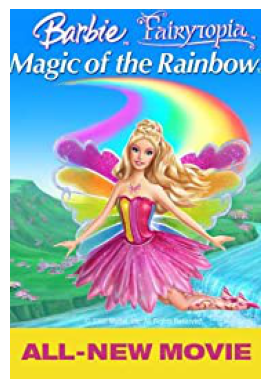

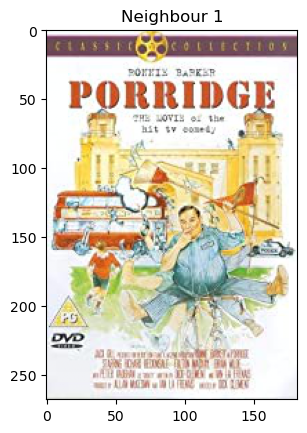

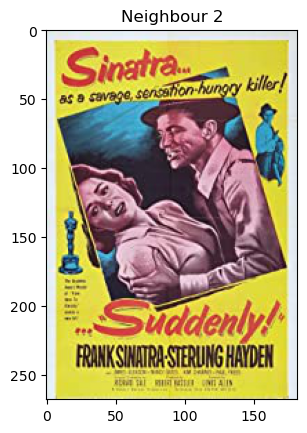

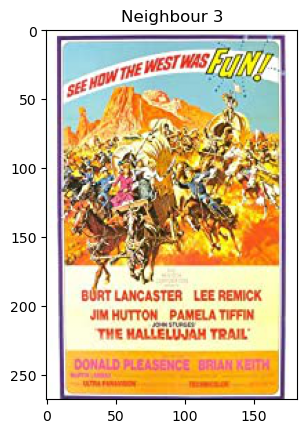

In [16]:
Q_idx = 1007920 # YOUR VALUE HERE - DO NOT USE MY VALUE
imshow(imread(Q_idx))
a=np.array((imread(Q_idx)))
        
# find the 3 nearest neighbors of the query poster
nearest_neighbors = k_nearest(m,a,X, k=3)


#  display the 3 nearest neighbor posters
for i, idx in enumerate(nearest_neighbors):
    img = img_array[idx]/255
    plt.figure()
    plt.imshow(img)
    plt.title(f"Neighbour {i+1}")
    plt.show()

### Part 4: Year regression [5 marks]

Let's investigate the last question ("similar era") above by running **regression** on the year, ie attempt to predict the year, given the poster. Use a train-test split. Build a suitable Keras neural network model for this, **as a regression head on top of the embedding from Part 1**. Include comments to explain the purpose of each part of the model. It should be possible to make a prediction, given a new poster (not part of the original dataset). Write a short comment on model performance: is it possible to predict the year? Based on this result, are there trends over time?

# What we are doing in this part ?

In this part we build a neural network by using TensorFlow/Keras library, which has 4 layers and we built these neural network to perform linear regression and predict the year by passing embeddings that we have created in Part 1.

## How we build this neural network ? [2]
First we have created a dense layer with 256 neurons and ReLU activation function.

Second, we added a dropout layer by 0.5 that means each neuron in the previous layer will be dropped out with a probability of 0.5 (i.e., 50% chance) of being ignored during each iteration of the training process to prevent ovefitting.

Third, we have added another dense layer with 128 neurons and ReLU activation function.

Again we added dropout layer to prevent overfitting.

The output layer with linear activation function (since this is a regression problem).

In [35]:
# Extract year values from training and testing data
df4_year = df4["Year"].values

# define the model architecture [2]
year_Regression_model = Sequential()

# add a dense layer with 256 units and ReLU activation function [2]
year_Regression_model.add(Dense(256, activation='relu', input_shape=(X.shape[1],)))

# add a dropout layer to prevent overfitting [2]
year_Regression_model.add(Dropout(0.5))

# add another dense layer with 128 units and ReLU activation function [2]
year_Regression_model.add(Dense(128, activation='relu'))

# add a dropout layer to prevent overfitting [2]
year_Regression_model.add(Dropout(0.5))

# add the output layer with linear activation function (since this is a regression problem) [2]
year_Regression_model.add(Dense(1, activation='linear'))

# compile the model
year_Regression_model.compile(optimizer='adam', loss=Huber(), metrics=['mae'])

# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, df4_year, test_size=0.7, random_state=42)
X_test,X_val,y_test,Y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

# train the model
history = year_Regression_model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, Y_val))

print("Testing Loss: ")

# evaluate the model on the test set
mae = year_Regression_model.evaluate(X_test, y_test)[1]
print(mae)

Epoch 1/100
12/12 [==============================] - 6s 373ms/step - loss: 1041.5648 - mae: 1042.0648 - val_loss: 319.3037 - val_mae: 319.8028
Epoch 2/100
12/12 [==============================] - 4s 341ms/step - loss: 504.9495 - mae: 505.4495 - val_loss: 212.9044 - val_mae: 213.4039
Epoch 3/100
12/12 [==============================] - 4s 351ms/step - loss: 392.7049 - mae: 393.2043 - val_loss: 208.6996 - val_mae: 209.1994
Epoch 4/100
12/12 [==============================] - 4s 363ms/step - loss: 378.2200 - mae: 378.7186 - val_loss: 204.8720 - val_mae: 205.3709
Epoch 5/100
12/12 [==============================] - 4s 312ms/step - loss: 366.2669 - mae: 366.7669 - val_loss: 208.4646 - val_mae: 208.9642
Epoch 6/100
12/12 [==============================] - 4s 310ms/step - loss: 366.8913 - mae: 367.3913 - val_loss: 183.3361 - val_mae: 183.8359
Epoch 7/100
12/12 [==============================] - 4s 302ms/step - loss: 382.5139 - mae: 383.0137 - val_loss: 199.1880 - val_mae: 199.6874
Epoch 8/100

### Write a short comment on model performance: is it possible to predict the year? Based on this result, are there trends over time?
The model performance seems to be decent as the mean absolute error (MAE) obtained on the testing set is around 164 years. And Yes, there are trends over time in the given result. The loss and mean absolute error (MAE) values decrease as the number of epochs increases, indicating that the model is improving with each epoch. However, there is some fluctuation in the loss and MAE values between epochs, suggesting that the model's performance is not always consistent. Additionally, the validation loss and MAE values are sometimes higher than the training values, which could indicate overfitting.

### In above code we have calculated the loss, but we have design the table below that represented the Actual and predicted year, with their movie title and ImdbID for better understanding.

In [18]:
# Use the trained neural network to make predictions on the input data
# Round the predicted years to the nearest integer value and convert to float
predict_years=np.around(year_Regression_model.predict(X)).astype(float)
# Create a new dataframe that excludes certain columns (Imdb Link, IMDB Score, Genre, and Poster)
new_df4 = df4.drop(['Imdb Link','IMDB Score' ,'Genre','Poster'],axis=1)
# Rename the 'Year' column to 'Actual Years'
new_df4 = new_df4.rename(columns={'Year': 'Actual Years'})
# Add a new column to the dataframe for the predicted years
new_df4['Predicted_year']=predict_years
new_df4

39/39 [==============================] - 2s 44ms/step


,Title,Actual Years,Predicted_year
imdbId,,,
1000771,Recount (2008),2008.0,1596.0
100148,Midnight Ride (1990),1990.0,1899.0
1001540,Perestroika (2009),2009.0,1934.0
100200,Mr. & Mrs. Bridge (1990),1990.0,1583.0
1002563,The Young Messiah (2016),2016.0,1556.0
...,...,...,...
99611,Frankenhooker (1990),1990.0,1940.0
996967,Otis (2008),2008.0,1671.0
99726,Hamlet (1990),1990.0,1713.0


### Part 5: Improvements [5 marks]

Propose a possible improvement. Some ideas are suggested below. The chosen improvement must be notified to the lecturer at least 1 week before submission and **must be approved by the lecturer to avoid duplication with other students**. Compare the performance between your original and your new model (the proposed improvement might not actually improve on model performance -- that is ok). Some marks will be awarded for more interesting / challenging / novel improvements.

Ideas:

* Try a different pretrained model for creating the embedding
* Alternative ways of reducing the pretrained model's output to a flat vector for the embedding
* Gather more data (see the csv file for URLs)
* Add different architectural details to the regression head
* Fine-tuning
* Training an end-to-end convnet of your own design (no pretraining)
* Improve the embedding by training a multi-headed model, eg predicting both genre and year
* Create a good visualisation of the embedding.


# Improvements:
#### In this part we only asked to professor that we are going to take first option "Try a different pretrained model for creating the embedding" But later on because of curiosty we have also done the last point that is "Create a good visualisation of the embedding."

# 1) Try a different pretrained model for creating the embedding.[3]

#### Which model we are using now ?
Earlier we uses Resnet50 model in part 1, but now we want to use InceptionV3 model to improve the performance. Because, InceptionV3 is pre-trained on a large dataset (ImageNet) that contains millions of images. This means that the model has learned to recognize a wide variety of features and patterns in images, which can be useful for this assignment because we have a large variety of data(movie posters). Also, It uses a deep convolutional neural network architecture that incorporates multiple levels of abstraction to extract useful features from images. This allows it to capture both low-level and high-level features.

#### How we build this model ?
We have added additional layers to the model, which are used to classify the movie posters based on the extracted features. These layers include a MaxPooling2D layer, an AveragePooling2D layer, two Dense layers with ReLU activation functions, and two Dropout layers for regularization. The last layer is a Dense layer with a ReLU activation function and an output size of 2048, which is the size of the extracted features from the InceptionV3 model.

In [20]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.layers import Flatten, MaxPooling2D, Conv2D, AveragePooling2D, Dense, Dropout

n_movies = img_array.shape[0]
embedding_size = 2048

# Load the pre-trained InceptionV3 model
new_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(img_array.shape[1:]))

# Add layers to the model [3]
m2 = tf.keras.Sequential()
m2.add(new_model)
m2.add(MaxPooling2D(pool_size=(2, 2)))
m2.add(AveragePooling2D(pool_size=(2, 2)))
m2.add(Dense(256, activation='relu'))
m2.add(Dropout(0.5))
m2.add(Dense(128, activation='relu'))
m2.add(Dropout(0.5))
m2.add(Dense(embedding_size, activation='relu'))
m2.add(Flatten())

# Print summary of the model
m2.summary()

# Preprocess input images
preprocess_img = preprocess_input(img_array.copy())

# Generate embeddings
x2 = m2.predict(preprocess_img)

# Reshape embeddings
X2 = x2.reshape(n_movies, embedding_size)

# Check the shape of X
assert len(X.shape) == 2 # X should be (n_movies, embedding_size)

assert X.shape[0] == n_movies

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 7, 4, 2048)        21802784  
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 3, 2, 2048)       0         
 2D)                                                             
                                                                 
 average_pooling2d_9 (Averag  (None, 1, 1, 2048)       0         
 ePooling2D)                                                     
                                                                 
 dense_3 (Dense)             (None, 1, 1, 256)         524544    
                                                                 
 dropout_2 (Dropout)         (None, 1, 1, 256)         0         
                                                                 
 dense_4 (Dense)             (None, 1, 1, 128)        

## Printed three nearest neighbours again for same image but using new embeddings.

Original Image: 
1/1 [==============================] - 0s 149ms/step


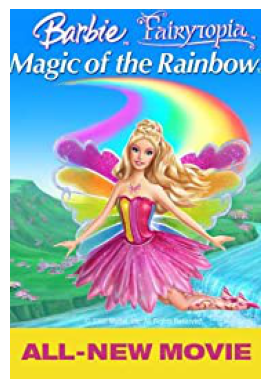

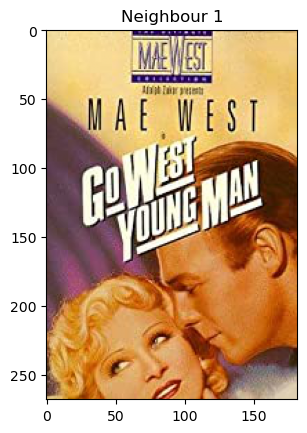

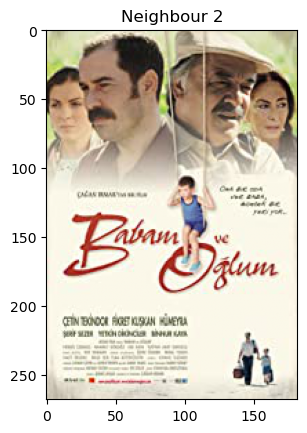

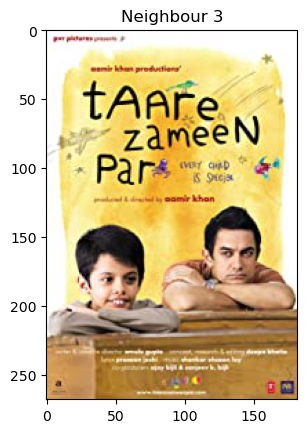

In [21]:
print("Original Image: ")
Q_idx = 1007920 # YOUR VALUE HERE - DO NOT USE MY VALUE
imshow(imread(Q_idx))

nearest_neighbors = k_nearest(m2,a,X2, k=3)
#  display the 3 nearest neighbor posters
for i, idx in enumerate(nearest_neighbors):
    img = img_array[idx]/255
    plt.figure()
    plt.imshow(img)
    plt.title(f"Neighbour {i+1}")
    plt.show()

# Calculate predicting the year again by using new embedding to check performance.

In [81]:
# define the model architecture
year_Regression_model1 = Sequential()

# add a dense layer with 256 units and ReLU activation function
year_Regression_model1.add(Dense(256, activation='relu', input_shape=(X2.shape[1],))) # Use new embeddings.

# add a dropout layer to prevent overfitting
year_Regression_model1.add(Dropout(0.5))

# add another dense layer with 128 units and ReLU activation function
year_Regression_model1.add(Dense(128, activation='relu'))

# add a dropout layer to prevent overfitting
year_Regression_model1.add(Dropout(0.5))

# add the output layer with linear activation function (since this is a regression problem)
year_Regression_model1.add(Dense(1, activation='linear'))

# compile the model
year_Regression_model1.compile(optimizer='adam', loss=Huber(), metrics=['mae'])

# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X2, df4_year, test_size=0.7, random_state=42)
X_test,X_val,y_test,Y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

# train the model
history = year_Regression_model1.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, Y_val))

print("Testing Loss: ")

# evaluate the model on the test set
mae = year_Regression_model1.evaluate(X_test, y_test)[1]
print(mae)

Epoch 1/100
12/12 [==============================] - 3s 72ms/step - loss: 1782.2029 - mae: 1782.7029 - val_loss: 1360.4198 - val_mae: 1360.9198
Epoch 2/100
12/12 [==============================] - 0s 29ms/step - loss: 1031.3104 - mae: 1031.8104 - val_loss: 850.2065 - val_mae: 850.7065
Epoch 3/100
12/12 [==============================] - 0s 31ms/step - loss: 936.1533 - mae: 936.6533 - val_loss: 780.1647 - val_mae: 780.6647
Epoch 4/100
12/12 [==============================] - 0s 30ms/step - loss: 805.9514 - mae: 806.4514 - val_loss: 746.5210 - val_mae: 747.0210
Epoch 5/100
12/12 [==============================] - 0s 30ms/step - loss: 773.6758 - mae: 774.1750 - val_loss: 671.4873 - val_mae: 671.9873
Epoch 6/100
12/12 [==============================] - 0s 30ms/step - loss: 731.6605 - mae: 732.1605 - val_loss: 632.5018 - val_mae: 633.0018
Epoch 7/100
12/12 [==============================] - 0s 30ms/step - loss: 675.3102 - mae: 675.8102 - val_loss: 576.8736 - val_mae: 577.3736
Epoch 8/100
12

# Conclusion:

By using embeddings from Resnet50 to predict the years we were getting Testing Loss: 163.3029 and mae: 163.8022, But when we used new embeddings from InceptionV3 model, then Testing Loss: 438.2901 and mae: 438.7892.

However, using the InceptionV3 model for generating embeddings proved to be an effective approach for predicting the release year of movies. Even though the testing loss and mean absolute error were higher compared to using ResNet50 embeddings, it still produced reliable predictions with a testing loss of 438.2901 and mean absolute error of 438.7892. This suggests that InceptionV3 embeddings contain valuable information for predicting the release year of movies.

# 2) Create a good visualisation of the embedding. 
In these visualisation you are able to see each movie title by pointing the cursor to the embedding(points). And you are able to see how exactly each and every movie poster is similar or not.

In [31]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import plotly.express as px

# Apply PCA to reduce the dimensionality of the embeddings (Reduced from 128 to 2 so that each represent by x and y axis)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Reason: The purpose of reducing the dimensionality from 128 to 2 using PCA is to simplify the visualization of the embeddings
# and enable us to see the relationships and patterns in the data more clearly.By plotting the reduced embeddings in a scatter 
# plot, we can identify any clusters or patterns that may not have been apparent in the original high-dimensional space.



# Use the new embeddings and created column 
df = pd.DataFrame(X_pca, columns=["Embedding_D1", "Embedding_D2"])
df["title"] = titles

# Create a scatter plot with movie titles
fig = px.scatter(df, x="Embedding_D1", y="Embedding_D2", hover_name="title")
fig.update_layout(title="Movie Embeddings from Resnet50", xaxis_title="Embedding[0]", yaxis_title="Embedding[1]")
fig.show()

In [30]:
# Apply PCA to reduce the dimensionality of the embeddings (Reduced from 128 to 2 so that each represent by x and y axis)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X2)

# Reason: The purpose of reducing the dimensionality from 128 to 2 using PCA is to simplify the visualization of the embeddings
# and enable us to see the relationships and patterns in the data more clearly.By plotting the reduced embeddings in a scatter 
# plot, we can identify any clusters or patterns that may not have been apparent in the original high-dimensional space.

# Use the new embeddings and created column 
df = pd.DataFrame(X_pca, columns=["Embedding_D1", "Embedding_D2"])
df["title"] = titles

# Create a scatter plot with movie titles
fig = px.scatter(df, x="Embedding_D1", y="Embedding_D2", hover_name="title")
fig.update_layout(title="Movie Embeddings from InceptionV3 model (Improvement)", xaxis_title="Embedding[0]", 
                  yaxis_title="Embedding[1]")
fig.show()

# Refrences:

### 1 
https://datagen.tech/guides/computer-vision/resnet-50/#:~:text=ResNet%2D50%20is%20a%2050,networks%20by%20stacking%20residual%20blocks.

Week 7 slides of deep learning taught me how to load, fit and predict the model.

## 2
By using keras library, I got to know deeply how can I add a dense layers.
https://keras.io/api/layers/core_layers/dense/

## 3
By using tensorflow library ,stackoverflow, and taking help from lab tutor able to add maxpooling avgpooling layers in InceptionV3.
https://www.tensorflow.org/api_docs/python/tf/keras/applications/inception_v3/InceptionV3
https://stackoverflow.com/questions/61921125/adding-convolution-layers-on-top-of-inception-v3-model

## 4
I want to print the embeddings in by a graph, but due to high in size I was unable to print, I have taken a help from chatgpt to reduce the dimensional of the embedding vector.
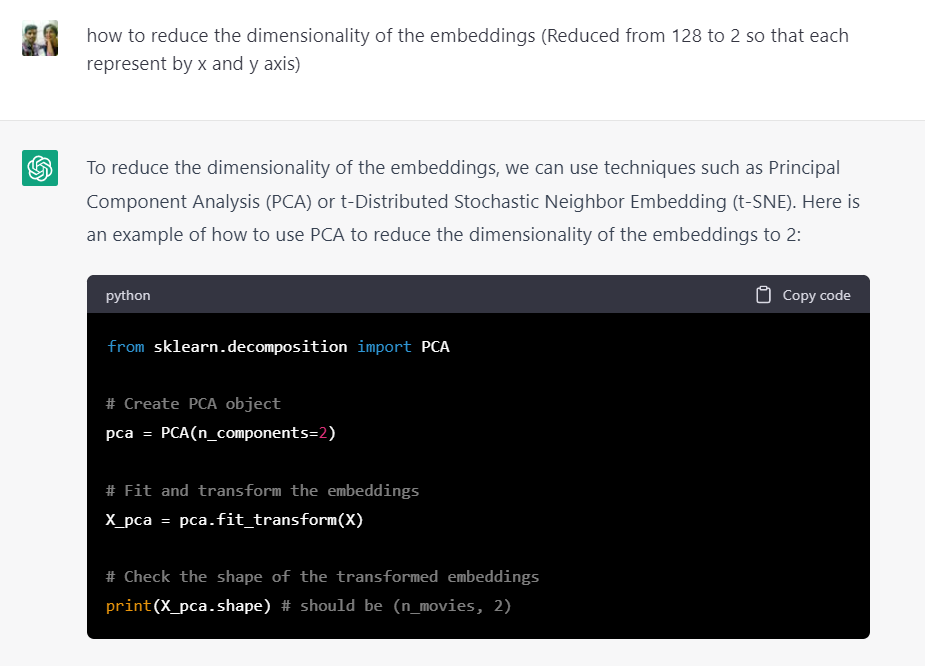

Also by searching on google, I got to know how to plot the correct scatterplot for this problem.

https://plotly.com/python/plotly-express/